<a href="https://colab.research.google.com/github/Vinda29/Prediksi-gagal-ginjal/blob/main/Prediksi_gagal_ginjal_menggunakan_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install imbalanced-learn

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

In [33]:
# 1. Membaca data
data_path = '/content/kidney_disease.csv'
data = pd.read_csv(data_path)

In [34]:
# Menampilkan informasi awal tentang data
print("Informasi Dataset:")
data.info()
print("\nStatistik Deskriptif:\n", data.describe(include='all'))

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              

# Data Preprocessing

In [35]:
# 2. Data preprocessing
# Mengatasi nilai yang hilang
print("\nJumlah nilai hilang:\n", data.isnull().sum())
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)


Jumlah nilai hilang:
 id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


In [36]:
# Memastikan semua nilai null terisi
for column in data_imputed.columns:
    # Mengambil nilai terbanyak (modus) untuk kolom tersebut
    most_frequent_value = data_imputed[column].mode()[0]
    # Mengisi nilai yang hilang dengan modus
    data_imputed[column] = data_imputed[column].fillna(most_frequent_value)

print("\nJumlah nilai hilang setelah penanganan:\n", data_imputed.isnull().sum())


Jumlah nilai hilang setelah penanganan:
 id                0
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64


<ipython-input-36-73dc02126631>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_imputed[column] = data_imputed[column].fillna(most_frequent_value)


In [37]:
# Encoding kolom kategori jika ada
label_encoders = {}
for column in data_imputed.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_imputed[column] = le.fit_transform(data_imputed[column])
    label_encoders[column] = le

In [38]:
# Memisahkan fitur dan target
X = data_imputed.drop('classification', axis=1, errors='ignore')  # Pastikan nama kolom target benar
y = data_imputed['classification'] if 'classification' in data_imputed.columns else None

In [39]:
# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# EDA

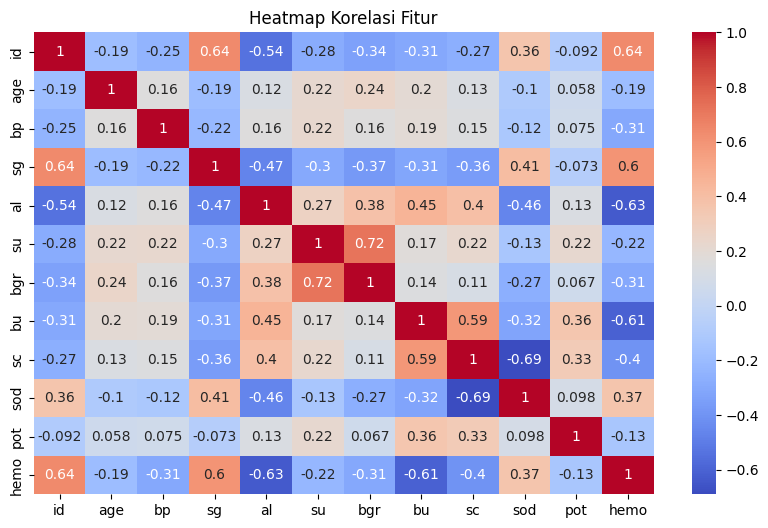

In [40]:
# 3. Eksplorasi Data Analitik (EDA)
plt.figure(figsize=(10, 6))
# Calculate correlation on numerical features only
numeric_data = data.select_dtypes(include=np.number)
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

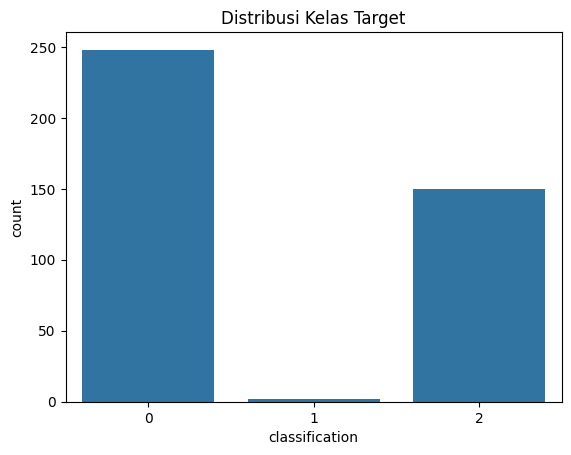

In [41]:
# Distribusi target
if y is not None:
    sns.countplot(x=y)
    plt.title("Distribusi Kelas Target")
    plt.show()

In [44]:
# Oversampling dengan SMOTE
# Define the technique variable
technique = 'oversampling'  # Or 'other_technique' if you don't want to oversample

# Check the minority class size
minority_class_size = y.value_counts().min()

# Adjust k_neighbors to a value less than or equal to the smallest minority class size
k_neighbors = min(minority_class_size -1 , 2)  # Use min to ensure k_neighbors is always valid
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)  # Changed k_neighbors dynamically
X_resampled, y_resampled = smote.fit_resample(X_selected, y)
X_used, y_used = X_resampled, y_resampled

# Seleksi Fitur

In [48]:
# 4. Seleksi fitur
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
print("\nFitur terpilih:", selected_features)


Fitur terpilih: Index(['id', 'sg', 'al', 'sod', 'hemo', 'pcv', 'rc', 'htn', 'dm', 'appet'], dtype='object')


# Modeling dan Evaluasi

In [21]:
# 5. Modeling dan evaluasi
# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [22]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print("\nRandom Forest Evaluation")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest Evaluation
[[52  0]
 [ 0 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        28

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Accuracy: 1.0
